# Bag of N grams tutorial


Let's first understand how to generate n-grams using CountVectorizer


In [1]:
from sklearn.feature_extraction.text import CountVectorizer

v = CountVectorizer()
v.fit(["Thor Hathodawala is looking for a job"])
v.vocabulary_

{'thor': 5, 'hathodawala': 1, 'is': 2, 'looking': 4, 'for': 0, 'job': 3}

In [2]:
v = CountVectorizer(ngram_range=(1,2))
v.fit(["Thor Hathodawala is looking for a job"])
v.vocabulary_

{'thor': 9,
 'hathodawala': 2,
 'is': 4,
 'looking': 7,
 'for': 0,
 'job': 6,
 'thor hathodawala': 10,
 'hathodawala is': 3,
 'is looking': 5,
 'looking for': 8,
 'for job': 1}

In [3]:
v = CountVectorizer(ngram_range=(1,3))
v.fit(["Thor Hathodawala is looking for a job"])
v.vocabulary_

{'thor': 12,
 'hathodawala': 2,
 'is': 5,
 'looking': 9,
 'for': 0,
 'job': 8,
 'thor hathodawala': 13,
 'hathodawala is': 3,
 'is looking': 6,
 'looking for': 10,
 'for job': 1,
 'thor hathodawala is': 14,
 'hathodawala is looking': 4,
 'is looking for': 7,
 'looking for job': 11}

In [4]:
corpus = [
    "Thor ate pizza",
    "Loki is tall",
    "Loki is eating pizza"
]

In [5]:
import spacy

# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm") 

def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    
    return " ".join(filtered_tokens) 

In [6]:
preprocess("Thor ate pizza")

'thor eat pizza'

In [7]:
preprocess("Loki is eating pizza")

'Loki eat pizza'

In [8]:
corpus_processed = [
    preprocess(text) for text in corpus
]
corpus_processed

['thor eat pizza', 'Loki tall', 'Loki eat pizza']

In [9]:
v = CountVectorizer(ngram_range=(1,2))
v.fit(corpus_processed)
v.vocabulary_

{'thor': 7,
 'eat': 0,
 'pizza': 5,
 'thor eat': 8,
 'eat pizza': 1,
 'loki': 2,
 'tall': 6,
 'loki tall': 4,
 'loki eat': 3}

Now generate bag of n gram vector for few sample documents



In [10]:
v.transform(["Thor ate pizza"]).toarray()

array([[0, 0, 0, 0, 0, 1, 0, 1, 0]])

Let's take a document that has <b>out of vocabulary (OOV)</b> term and see how bag of ngram generates vector out of it

In [11]:
v.transform(["Hulk eat pizza"]).toarray()

array([[1, 1, 0, 0, 0, 1, 0, 0, 0]])

<b>News Category Classification Problem</b>
Okay now that we know basics of BAG of n grams vectorizer 😎 It is the time to work on a real problem. Here we want to do a news category classification. We will use bag of n-grams and traing a machine learning model that can categorize any news into one of the following categories,

1. BUSINESS
2. SPORTS
3. CRIME
4. SCIENCE

<b>Dataset</b>
Dataset Credits: https://www.kaggle.com/code/hengzheng/news-category-classifier-val-acc-0-65

* This data consists of two columns. - Text - Category
* Text is a news article
* Category can be one of these 4: 'BUSINESS', 'SPORTS', 'CRIME', 'SCIENCE', to keep things simple I trimmed additional categories from the original dataset

In [15]:
import pandas as pd

df = pd.read_json("news_dataset.json")
print(df.shape)

df.head()

(12695, 2)


,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [16]:
df.category.value_counts()

category
BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: count, dtype: int64

<b> Handle class imbalance</b>

As you can see above, SCIENCE category has almost 1/3rd data samples compared to BUSINESS and SPORTS categories.we need to address this imbalanced.

In undersampling, we take a minor class and sample those many samples from other classes, this means we are not utilizing all the data samples for training and in ML world - Not using all the data for training is considered a SIN! 😵 In real life, you are advised to use a technique such as SMOTE so that you can utilize all of your dataset for the training but since this tutorial is more about bag of n-grams then class imbalance itself, I'd go with a simple technique of undersampling.

In [22]:
min_samples = 1381

df_business = df[df.category=="BUSINESS"].sample(min_samples, random_state=7)
df_sports = df[df.category == "SPORTS"].sample(min_samples, random_state = 7)
df_crime = df[df.category == "CRIME"].sample(min_samples, random_state = 7)
df_science = df[df.category == "SCIENCE"].sample(min_samples, random_state = 7)

In [23]:
df_balanced = pd.concat([df_business,df_sports,df_crime,df_science],axis=0)
df_balanced.category.value_counts()

category
BUSINESS    1381
SPORTS      1381
CRIME       1381
SCIENCE     1381
Name: count, dtype: int64

<b>Convert text category to a number</b>

In [25]:
target = {'BUSINESS': 0, 'SPORTS': 1, 'CRIME': 2, 'SCIENCE': 3}

df_balanced['category_num'] = df_balanced['category'].map({
    'BUSINESS': 0,
    'SPORTS': 1, 
    'CRIME': 2, 
    'SCIENCE': 3
})

In [26]:
df_balanced.head()

,text,category,category_num
7146,Why Onboarding New Funding Is Like Onboarding ...,BUSINESS,0
6749,Trump's Big Economic Policy Address Is Short O...,BUSINESS,0
5305,Remember the Old Days When Bad Guys Robbed Ban...,BUSINESS,0
5308,"Women in Business Q&A: Nawal Motawi, Motawi Te...",BUSINESS,0
10674,The Net Worth of Each Presidential Candidate T...,BUSINESS,0


<b>Build a model with original text (no pre processing)</b>

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.text, 
    df_balanced.category_num, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=7,
    stratify=df_balanced.category_num
)

In [29]:
print(X_train.shape)
X_train.head()

(4419,)


9777    This Swimsuit Cleans The Ocean As You Swim Cal...
3499    Two West Virginia Towns Evacuated After Oil Tr...
4777    Influential NBA Agent Dan Fegan Dead In Car Cr...
9052                             Carjacking Victims ID'd 
9442    Alabama Students Will Finally Be Required To L...
Name: text, dtype: object

In [30]:
y_train.value_counts()

category_num
2    1105
1    1105
0    1105
3    1104
Name: count, dtype: int64

In [32]:
y_test.value_counts()

category_num
3    277
0    276
2    276
1    276
Name: count, dtype: int64

<b>Attempt 1 : Use 1-gram which is nothing but a Bag Of Words (BOW) model</b>

In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_bow', CountVectorizer(ngram_range = (1, 1))),        #using the ngram_range parameter 
     ('Multi NB', MultinomialNB())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       276
           1       0.91      0.82      0.86       276
           2       0.86      0.89      0.87       276
           3       0.90      0.81      0.86       277

    accuracy                           0.86      1105
   macro avg       0.86      0.86      0.86      1105
weighted avg       0.86      0.86      0.86      1105



In [34]:
X_test[:5]

11328    What is Poor Customer Support Costing Your Bus...
8719     DON'T PANIC! That Bacon Shortage You Keep Hear...
1606     One Dead After Rockfall On Yosemite's Famed El...
8917     (VIDEO) Publicis' Lévy Says, In Future, 'Ideas...
1734     Couple Face Cruelty Charges For Living In Plyw...
Name: text, dtype: object

* BUSINESS: 0
* SPORTS: 1
* CRIME: 2
* SCIENCE: 3

In [35]:
y_pred[:5]

array([0, 0, 2, 3, 2])

In [36]:
y_test[:5]

11328    0
8719     0
1606     3
8917     0
1734     2
Name: category_num, dtype: int64

<b>Attempt 2 : Use 1-gram and bigrams</b>

In [38]:
#1. create a pipeline object
clf = Pipeline([
    ('vectorizer_1_2_gram', CountVectorizer(ngram_range = (1, 2))),        #using the ngram_range parameter 
     ('Multi NB', MultinomialNB())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.92      0.81       276
           1       0.92      0.78      0.85       276
           2       0.87      0.88      0.88       276
           3       0.91      0.78      0.84       277

    accuracy                           0.84      1105
   macro avg       0.85      0.84      0.84      1105
weighted avg       0.85      0.84      0.84      1105



<b>Attempt 3 : Use 1-gram to trigrams<b/>

In [39]:
#1. create a pipeline object
clf = Pipeline([
    ('vectorizer_1_3_grams', CountVectorizer(ngram_range = (1, 3))),        #using the ngram_range parameter 
     ('Multi NB', MultinomialNB())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.92      0.79       276
           1       0.92      0.77      0.84       276
           2       0.87      0.88      0.88       276
           3       0.91      0.75      0.82       277

    accuracy                           0.83      1105
   macro avg       0.85      0.83      0.83      1105
weighted avg       0.85      0.83      0.83      1105



<b>Use text pre-processing to remove stop words, punctuations and apply lemmatization</b>

You may wonder, we have not done any text-processing yet to remove stop words, punctuations, apply lemmatization etc. Well we wanted to train the model without any preprocessing first and check the performance. Now we will re-do same thing but with preprocessing of text

In [40]:
df_balanced['preprocessed_txt'] = df_balanced['text'].apply(preprocess) 

In [41]:
df_balanced.head()


,text,category,category_num,preprocessed_txt
7146,Why Onboarding New Funding Is Like Onboarding ...,BUSINESS,0,Onboarding New Funding like Onboarding New Peo...
6749,Trump's Big Economic Policy Address Is Short O...,BUSINESS,0,Trump Big Economic Policy Address short specif...
5305,Remember the Old Days When Bad Guys Robbed Ban...,BUSINESS,0,remember Old day Bad guy rob bank bad guy call...
5308,"Women in Business Q&A: Nawal Motawi, Motawi Te...",BUSINESS,0,woman Business Q&A Nawal Motawi Motawi Telewor...
10674,The Net Worth of Each Presidential Candidate T...,BUSINESS,0,Net Worth presidential Candidate U.S. presiden...


<b>Build a model with pre processed text</b>

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.preprocessed_txt, 
    df_balanced.category_num, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df_balanced.category_num
)

In [44]:
print(X_train.shape)
X_train.head()

(4419,)


11994    poll Future Past history Public Expectations F...
2397     New Map prove Astronauts tweet Best Pictures E...
3987     Munenori Kawasaki drunk Hilarious team Clinche...
448      37 ton David Victorson Tale Ballsy Redemption ...
12145    cop charge Laquan McDonald Murder Posts Bail B...
Name: preprocessed_txt, dtype: object

In [45]:
y_train.value_counts()

category_num
3    1105
2    1105
0    1105
1    1104
Name: count, dtype: int64

In [46]:
y_test.value_counts()

category_num
1    277
0    276
3    276
2    276
Name: count, dtype: int64

In [47]:
#1. create a pipeline object
clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range = (1, 2))),        #using the ngram_range parameter 
    ('Multi NB', MultinomialNB())
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       276
           1       0.92      0.88      0.90       277
           2       0.86      0.93      0.90       276
           3       0.89      0.81      0.85       276

    accuracy                           0.87      1105
   macro avg       0.87      0.87      0.87      1105
weighted avg       0.87      0.87      0.87      1105




If you compare above classification report for (1,2) gram with the one from unprocessed text, you will find some improvement in the model that uses preprocessed cleaned up text. Hence we can conclude that for this particular problem using preprocessing (removing stop words, lemmatization) is improving the performance of the model

<b>Plot confusion matrix</b>

In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[238,   8,  16,  14],
       [ 15, 243,  11,   8],
       [ 12,   1, 257,   6],
       [ 27,  12,  14, 223]])

Text(95.72222222222221, 0.5, 'Truth')

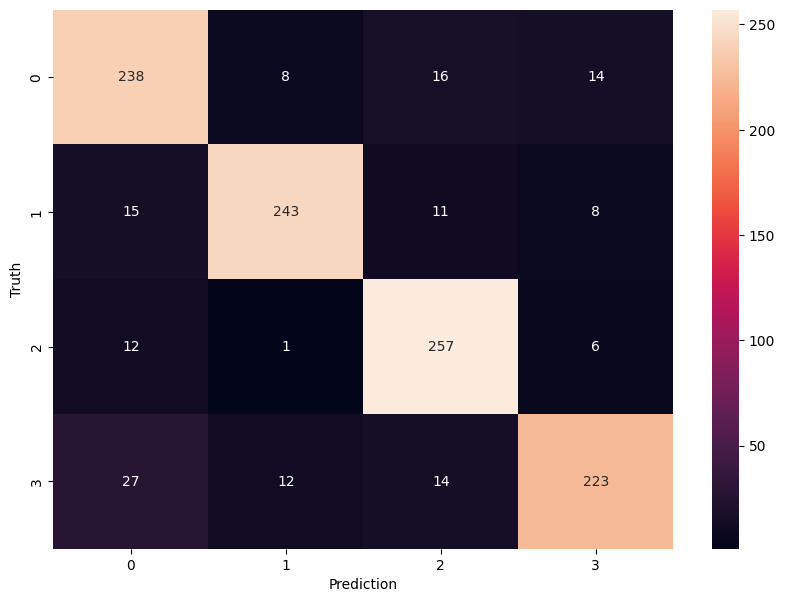

In [49]:
from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')